In [1]:
model_names = ['Original-Pretrained-R2plus1DMotionSegNet_model.pth']

In [2]:
def strain_value(l_0, l_i):
    '''
    inputs: l_0, l_i -- original length and new length at some time point, respectively
    output: e -- strain value (positive for elongation, negative for compressing/shortening)
    
    examples: 
        l_i = 10
        l_0 = 5
        e == (10 - 5) / 5 = 1, factor of lengthening relative to original value
        
        l_i = 5
        l_0 = 5
        e == (5 - 5) / 5 = 0, no strain
    '''
    return (l_i - l_0) / l_0

In [53]:
def rmse(x, y):
    ''' return root mean square error difference between the two values passed in'''
    return np.sqrt((x - y) ** 2)

In [3]:
import os
os.chdir("../..")

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset


from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet 

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet



# from src.visualization_utils import categorical_dice
%matplotlib widget
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [4]:
!pwd

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


In [5]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", raise_for_es_ed=False, subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

print(f'test dataset length: {len(test_dataset)}')


def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def get_all_possible_start_points(ed_index, es_index, video_length, clip_length):
    assert es_index - ed_index > 0, "not a ED to ES clip pair"
    possible_shift = clip_length - (es_index - ed_index)
    allowed_right = video_length - es_index
    if allowed_right < possible_shift:
        return np.arange(ed_index - possible_shift + 1, video_length - clip_length + 1)
    if possible_shift < 0:
        return np.array([ed_index])
    elif ed_index < possible_shift:
        return np.arange(ed_index + 1)
    else:
        return np.arange(ed_index - possible_shift + 1, ed_index + 1)
    
    
loaded_in_models = []

for model_name in model_names:
    model_save_path = f"save_models/{model_name}"
    
    # original model
    if model_name == "Original-Pretrained-R2plus1DMotionSegNet_model.pth":
        # model = DDP(R2plus1D_18_MotionNet())
         model = torch.nn.DataParallel(R2plus1D_18_MotionNet(), device_ids = [1, 0])
        
    # altered models
    if model_name == "dropout-0_75-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_75_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_75_R2plus1D_18_MotionNet())
    if model_name == "dropout-0_50-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_50_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_50_R2plus1D_18_MotionNet())
    if model_name == "dropout-0_25-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_25_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_25_R2plus1D_18_MotionNet())
    if model_name == "dropout-0_10-R2plus1DMotionSegNet_model.pth":
        # model = DDP(dropout_0_10_R2plus1D_18_MotionNet())
        model = torch.nn.DataParallel(dropout_0_10_R2plus1D_18_MotionNet())
    
    # dropout v2 models
    if model_name == 'dropout_v2-0_10-R2plus1DMotionSegNet_model.pth':
        model = torch.nn.DataParallel(dropout_v2_0_10_R2plus1D_18_MotionNet())
    
    #### TEMPORARY: use GPU 2 (cuda:1) because we were training another model simultaneously at the moment of writing.
    
    
    model.to(f'cuda:{model.device_ids[0]}')
    # model.to("cuda:1")
    torch.cuda.empty_cache()
    model.load_state_dict(torch.load(model_save_path)["model"])
    print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
    model.eval();
    
    loaded_in_models.append((model_name, model))

print(len(loaded_in_models))

100%|██████████| 16/16 [00:01<00:00, 13.70it/s]


test dataset length: 1276
Original-Pretrained-R2plus1DMotionSegNet_model.pth has 31575731 parameters.
1


In [6]:
test_pat_index = 0  # first video from test dataset

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

video.shape

(3, 248, 112, 112)

In [7]:
print(f'ed_index: {ed_index}, es_index: {es_index}')
print(f'shapes: {(ed_frame.shape, es_frame.shape)}')

ed_index: 132, es_index: 148
shapes: ((3, 112, 112), (3, 112, 112))


In [8]:
possible_starts = get_all_possible_start_points(ed_index, es_index, video.shape[1], clip_length=32)
print(f'len: {len(possible_starts)}, {possible_starts}')
print(possible_starts[-1])

len: 16, [117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132]
132


In [9]:
# prove to ourselves that in the first clip as listed above, our es index is the last frame (32nd frame) in our [0, 31] frames
print(f'{possible_starts[0] + 31} == {es_index}')

148 == 148


In [10]:
# segment clips by passing thru model, not consecutive 32 frame clips

# segment using all models
all_segmentation_outputs = []
all_motion_outputs = []

# for each model, segment the clips
for name, model in loaded_in_models:
    
    segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))
    motion_outputs = np.empty(shape=(1, 4, 32, 112, 112))
    for start in possible_starts:
        one_clip = np.expand_dims(video[:, start: start + 32], 0)
        segmentation_output, motion_output = model(torch.Tensor(one_clip))
        segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        motion_outputs = np.concatenate([motion_outputs, motion_output.cpu().detach().numpy()])
    segmentation_outputs = segmentation_outputs[1:]
    motion_outputs = motion_outputs[1:]
    
    # save 
    all_segmentation_outputs.append(segmentation_outputs)
    all_motion_outputs.append(motion_outputs)

In [11]:
# how many frames ahead is the ES frame relative to the ED frame?
delta_ed_es_frames = es_index - ed_index
delta_ed_es_frames

16

In [12]:
clip_to_grab_index = -1   # grab the last clip where ED frame is the first frame
model_num = 0             # which model's output to grab (0 if just using 1 model)

clip_with_ed_frame_index_0 = all_segmentation_outputs[model_num][clip_to_grab_index] 

clip_with_ed_frame_index_0.shape

(2, 32, 112, 112)

In [13]:
# for the dimension of 2 for seg out, 0 is background, 1 for lv

ed_frame_background_seg = clip_with_ed_frame_index_0[0][0]
es_frame_background_seg = clip_with_ed_frame_index_0[0][delta_ed_es_frames]


ed_frame_lv_seg = clip_with_ed_frame_index_0[1][0] # 1 for lv, 0 for ed frame index
es_frame_lv_seg = clip_with_ed_frame_index_0[1][delta_ed_es_frames] # 1 for lv, delta_ed_es_frames for es frame index


ed_frame_lv_seg.shape, es_frame_lv_seg.shape, ed_frame_background_seg.shape, es_frame_background_seg.shape

((112, 112), (112, 112), (112, 112), (112, 112))

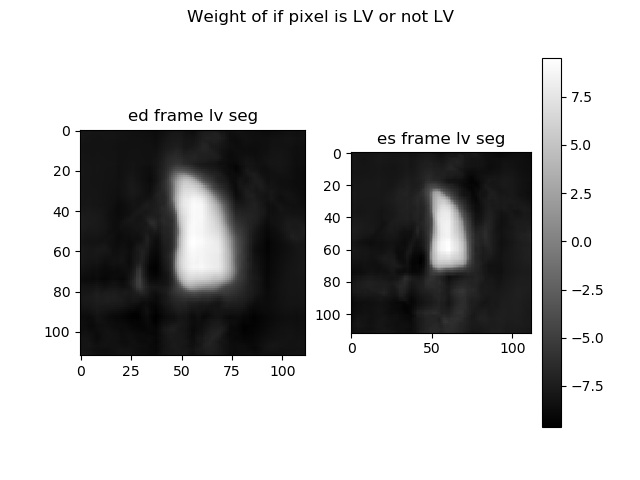

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle("Weight of if pixel is LV or not LV")

ax1.set_title('ed frame lv seg')
ax1.imshow(ed_frame_lv_seg, cmap="gray")

ax2.set_title('es frame lv seg')
ax2_img = ax2.imshow(es_frame_lv_seg, cmap="gray")  # this one is the labeling of the left ventricle segmentation
fig.colorbar(ax2_img, ax=ax2)

In [16]:
foo = np.argmax(clip_with_ed_frame_index_0, axis=0)
foo.shape

(32, 112, 112)

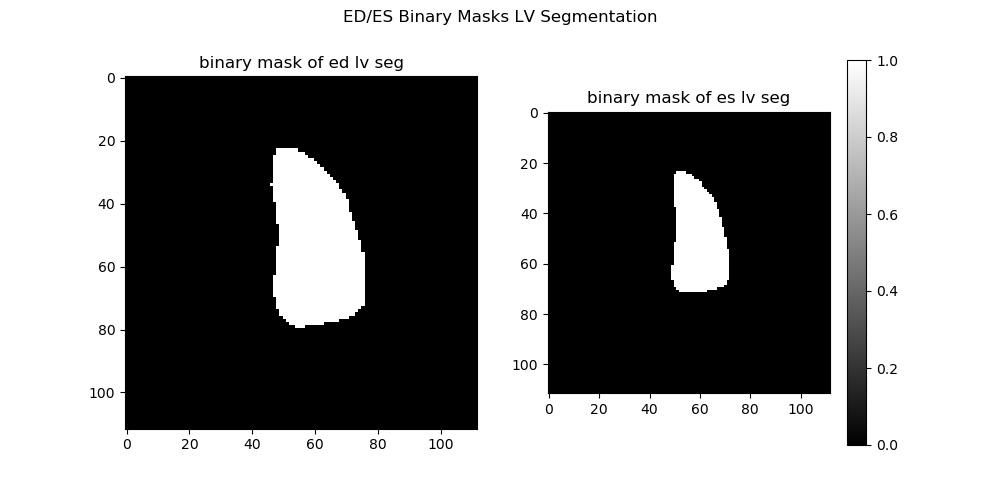

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

fig.suptitle("ED/ES Binary Masks LV Segmentation")

ax1.set_title('binary mask of ed lv seg')
ax1.imshow(foo[0], cmap="gray")

ax2.set_title('binary mask of es lv seg')
ax2_img = ax2.imshow(foo[delta_ed_es_frames], cmap="gray")
fig.colorbar(ax2_img, ax=ax2)

In [18]:
foo_times_255 = 255 * foo

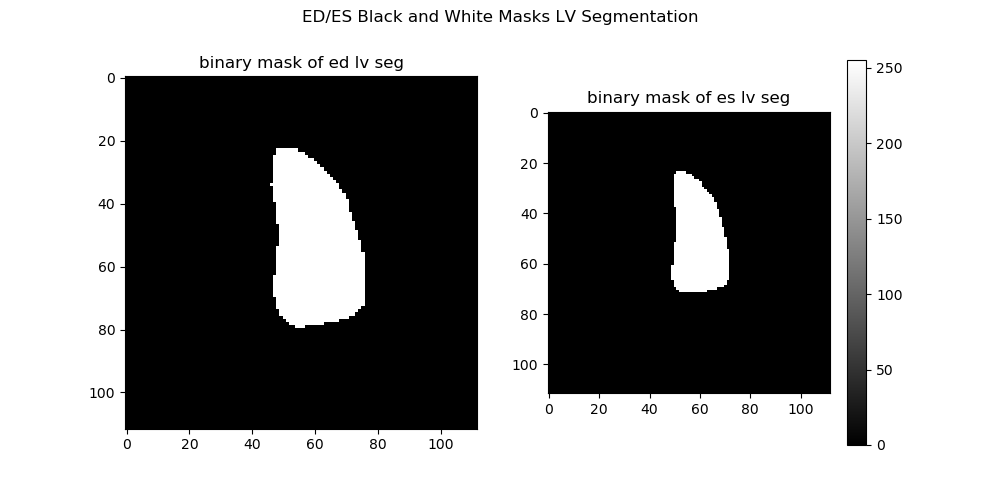

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

fig.suptitle("ED/ES Black and White Masks LV Segmentation")

ax1.set_title('binary mask of ed lv seg')
ax1.imshow(foo_times_255[0], cmap="gray")

ax2.set_title('binary mask of es lv seg')
ax2_img = ax2.imshow(foo_times_255[delta_ed_es_frames], cmap="gray")
fig.colorbar(ax2_img, ax=ax2)

In [20]:
image_8bit = np.uint8(foo * 255)   # convert to black and white and use 8-bit int data type

ed_im = image_8bit[0]
es_im = image_8bit[delta_ed_es_frames]

import cv2 as cv

ret, thresh = cv.threshold(ed_im, 127, 255, 0)
ed_contours, ed_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

ret, thresh = cv.threshold(es_im, 127, 255, 0)
es_contours, es_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

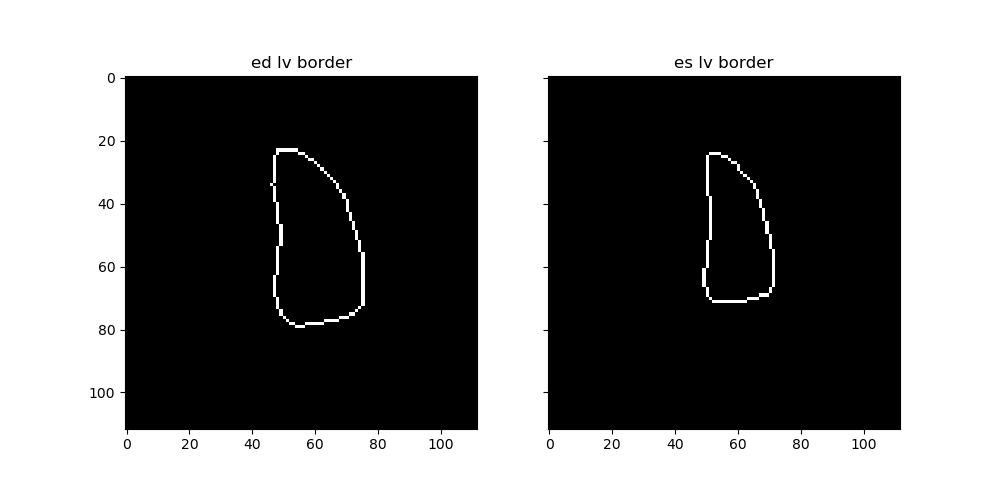

In [21]:
borders_list = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
ed_blank = np.zeros((112,112))

ax1.imshow(cv.drawContours(ed_blank, ed_contours, -1, (255,255,255), 1), cmap='gray')
ax1.set_title("ed lv border")
borders_list.append(ed_blank)

es_blank = np.zeros((112,112))
ax2.imshow(cv.drawContours(es_blank, es_contours, -1, (255,255,255), 1), cmap='gray')
ax2.set_title("es lv border")
borders_list.append(es_blank)

In [22]:
l_0 = np.count_nonzero(borders_list[0] == 255)
l_i = np.count_nonzero(borders_list[1] == 255)
strain_value(l_0, l_i)

-0.15555555555555556

## Try to start with the ED LV Seg frame and warp forwards `delta_ed_es_frames` times for a fake ES LV Seg frame. Calculate this "strain" and see ...

## Need a "ground truth" "strain" value to compare to. We will need to use the provided pixel datapoints from the dataset. Grab the manual segmentations of the ED/ES from the dataset.

In [47]:
list(map(lambda x : x.shape, [es_label, ed_label]))

[(112, 112), (112, 112)]

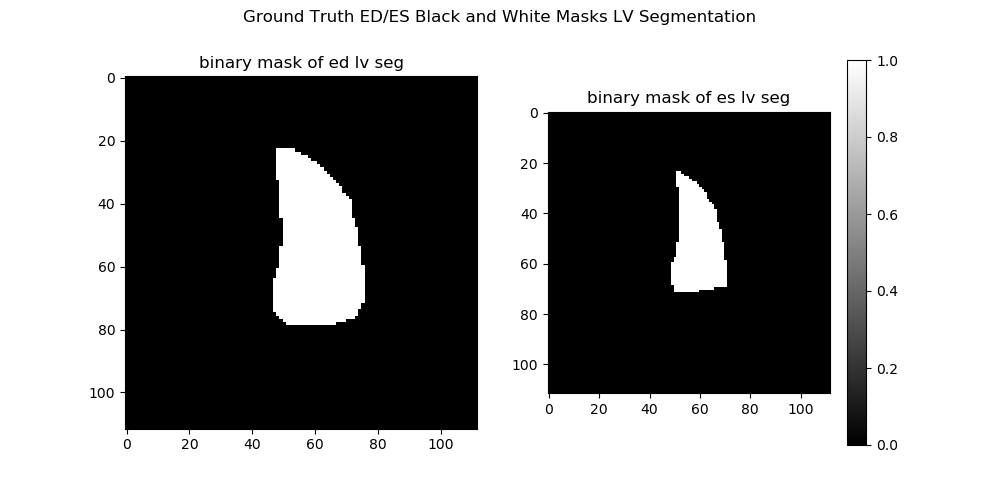

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

fig.suptitle("Ground Truth ED/ES Black and White Masks LV Segmentation")

ax1.set_title('binary mask of ed lv seg')
ax1.imshow(ed_label, cmap="gray")

ax2.set_title('binary mask of es lv seg')
ax2_img = ax2.imshow(es_label, cmap="gray")
fig.colorbar(ax2_img, ax=ax2)

In [50]:
# image_8bit = np.uint8(foo * 255)   # convert to black and white and use 8-bit int data type

ed_im = np.uint8(ed_label * 255)
es_im = np.uint8(es_label * 255)

import cv2 as cv

ret, thresh = cv.threshold(ed_im, 127, 255, 0)
ed_contours, ed_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

ret, thresh = cv.threshold(es_im, 127, 255, 0)
es_contours, es_hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

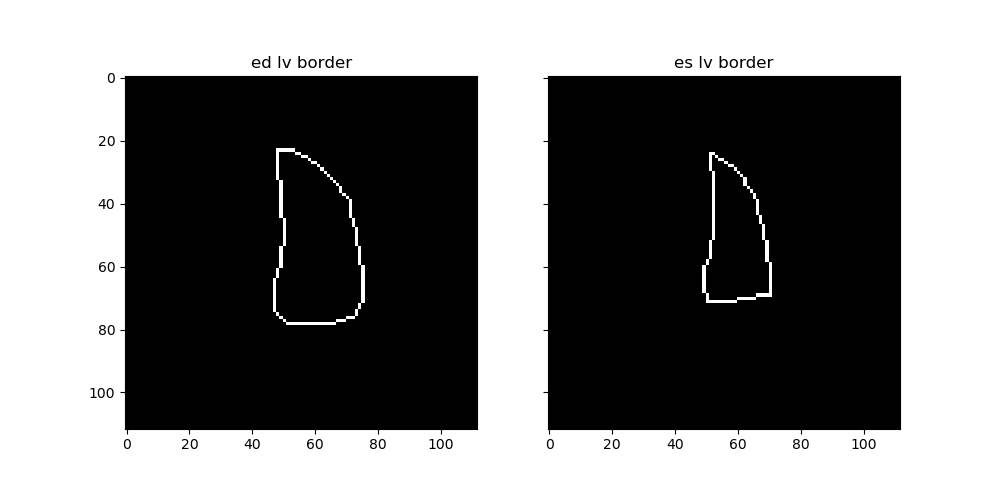

In [51]:
borders_list = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
ed_blank = np.zeros((112,112))

ax1.imshow(cv.drawContours(ed_blank, ed_contours, -1, (255,255,255), 1), cmap='gray')
ax1.set_title("ed lv border")
borders_list.append(ed_blank)

es_blank = np.zeros((112,112))
ax2.imshow(cv.drawContours(es_blank, es_contours, -1, (255,255,255), 1), cmap='gray')
ax2.set_title("es lv border")
borders_list.append(es_blank)

In [52]:
l_0 = np.count_nonzero(borders_list[0] == 255)
l_i = np.count_nonzero(borders_list[1] == 255)
strain_value(l_0, l_i)

-0.16058394160583941